Time of Flight until reaching target altitude: 27.69 seconds
Horizontal Distance traveled until reaching target altitude: 9989.67 meters
Max Ord: 974.63 meters
Drift: 52.55 meters


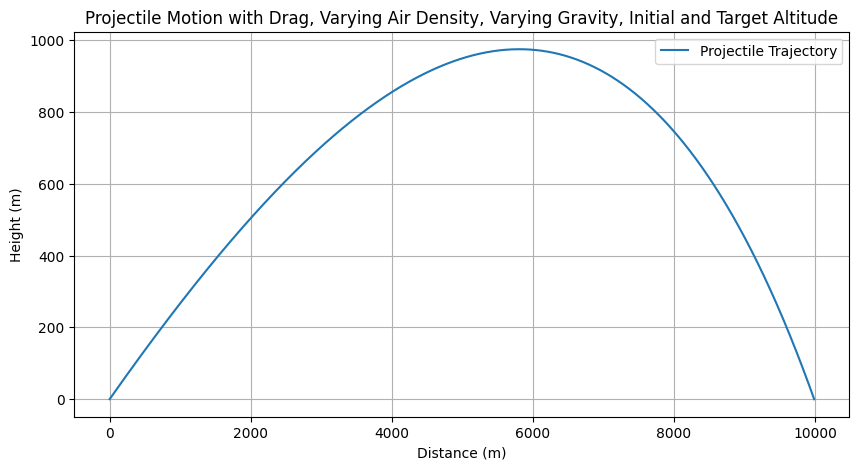

,t,x,y,z,vx,vy,vz,QE,v_mag,t2,x2,y2,drift,dx,dy,dt,qe2,v2
0,0.00,0.000000,0.000000,0.000000,542.610933,167.920740,0.000000,305.700000,568.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,5.424301,1.678055,0.000014,542.430108,167.805477,0.001446,305.598368,567.793185,0.008507,4.406614,1.229937,0.005893,4.406614,1.229937,0.008507,277.245169,537.801778
2,0.02,10.846795,3.354957,0.000043,542.249439,167.690241,0.002891,305.496625,567.586532,0.017014,8.811759,2.459030,0.008839,4.405146,1.229093,0.008507,277.151859,537.608907
3,0.03,16.267485,5.030707,0.000087,542.068926,167.575032,0.004335,305.394772,567.380042,0.025521,13.215439,3.687279,0.011785,4.403679,1.228248,0.008507,277.058449,537.416190
4,0.04,21.686370,6.705306,0.000144,541.888569,167.459850,0.005778,305.292809,567.173715,0.034028,17.617653,4.914683,0.014731,4.402214,1.227404,0.008507,276.964939,537.223627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3251,32.51,12285.769854,6.553814,52.428394,274.500911,-167.343663,2.916024,-557.647792,321.488183,27.656015,9980.758583,4.803646,9.434661,2.230001,-1.226553,0.008507,-512.210226,299.175132
3252,32.52,12288.514401,4.879226,52.457563,274.454669,-167.458794,2.916841,-558.035493,321.508652,27.664522,9982.988208,3.576250,9.437801,2.229625,-1.227396,0.008507,-512.578595,299.184265
3253,32.53,12291.258485,3.203487,52.486739,274.408434,-167.573952,2.917659,-558.423208,321.529187,27.673029,9985.217457,2.348009,9.440942,2.229249,-1.228240,0.008507,-512.947002,299.193454
3254,32.54,12294.002107,1.526595,52.515924,274.362205,-167.689137,2.918477,-558.810935,321.549788,27.681536,9987.446331,1.118925,9.444084,2.228874,-1.229085,0.008507,-513.315445,299.202699


In [35]:
# Here is my artillery Shot data calculations with coriolis removed because it is so small

from numpy import radians, sin, exp, cos, tan, sqrt, arctan, pi, log
import matplotlib.pyplot as plt
import pandas as pd

# Constants
gp = 9.832
# Inputs
# Example usage:
v0 = 568 #m/s
launch_angle = 305.7/3200*180 #mils to degrees
mass = 103.5/2.2 # lbs to kg
drag_coefficient = .25
radius = .155/2
area = radius**2*pi
latitude = 32 + 3/60 + 31/3600 # Frankfurt's approximate latitude
azimuth = 145/3200*180 # Firing due east
initial_altitude = 0 # Launch altitude in meters
target_altitude = 0 # Target altitude in meters
rho0 = 1.225 #float(input("Enter the air density at altitude (kg/m^3): "))
# Additional input for Magnus effect
spin_rate = v0/(20*.155) #float(input("Enter the projectile spin rate (revolutions per second): ")
spin_velocity = spin_rate * 2 * pi  # Convert from rev/s to rad/s


# Function to calculate gravitational acceleration with latitude
def gravity_with_latitude(latitude, gp=gp, alpha=0.0053024):
    latitude_rad = radians(latitude)
    return gp * (1 - alpha * cos(latitude_rad)**2)

# Function to calculate air density with altitude
def air_density_with_altitude(h, rho0=rho0, H=8500):
    return rho0 * exp(-h / H)

# Constants for Magnus effect
S = 0.0009 # This is an example value; you'll need to determine the appropriate value for your projectile

# Function to calculate the Magnus force
def magnus_force(v, spin_velocity, rho, area, S=S):
    # CL is the lift coefficient, which is dimensionless
    # spin_rate is in rad/s to be compatible with the velocity v in m/s
    CL = S * (spin_velocity / v)
    # Magnus force calculation, with v in m/s and area in m^2
    return CL * 0.5 * rho * area * v**2

# Function to calculate projectile motion with drag, varying air density, varying gravity
def projectile_motion_with_drag(v0, angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude):
    # Convert angle to radians
    angle_rad = radians(angle)
    
    # Initial velocity components
    v0x = v0 * cos(angle_rad)
    v0y = v0 * sin(angle_rad)
    # Velocity components
    vx = v0x
    vy = v0y
    vz = 0
    
    # Time step for simulation
    dt = 0.01
    t = 0
    x = 0
    y = initial_altitude  # Set the initial altitude
    z = 0  # z-axis for lateral drift
    
    # Lists to store the trajectory points
    t_time = []
    x_points = []
    y_points = []
    z_points = []  # z-axis for lateral drift
    vx_comp = []
    vy_comp = []
    vz_comp = []
    v_mag = []
    qe = []

    # Store the initial points
    t_time.append(t) # seconds
    x_points.append(x) # meters
    y_points.append(y) # meters
    z_points.append(z)  # z-axis for lateral drift
    vx_comp.append(v0x) # m/s
    vy_comp.append(v0y) # m/s
    vz_comp.append(0) # m/s
    v_mag.append(v0) # m/s
    qe.append(angle/180*3200) # trajectory in mils

    
    
    # Calculate the gravitational acceleration for the given latitude
    g = gravity_with_latitude(latitude)
    
    # Simulation loop
    while y >= 0:
        # Calculate the air density at current altitude
        rho = air_density_with_altitude(y)

        # Calculate the Magnus force
        # The velocity v is the magnitude of the velocity vector, in m/s
        F_magnus = magnus_force(sqrt(vx**2 + vy**2), spin_velocity, rho, area)
        
        # Calculate the drag force
        F_drag_x = - (drag_coefficient * rho * area * vx**2) / (2 * mass)
        F_drag_y = - (drag_coefficient * rho * area * vy**2) / (2 * mass)
        F_drag_z = - (drag_coefficient * rho * area * vz**2) / (2 * mass)
        F_total_z = F_magnus + F_drag_z
                   
        # Update velocities
        vx += F_drag_x * dt
        vy += (F_drag_y - g) * dt
        vz += F_total_z * dt / mass
        
        # Update positions
        t += dt
        x += vx * dt
        y += vy * dt
        z += vz * dt
        
        # Store the points
        t_time.append(t) # seconds
        x_points.append(x)
        y_points.append(y)
        z_points.append(z)  # z-axis for lateral drift
        vx_comp.append(vx) #m/s
        vy_comp.append(vy)# m/s
        vz_comp.append(vz)
        v_mag.append(sqrt(vx**2+vy**2)) # m/s
        qe.append(arctan(vy/vx)/pi*3200) #in mils
        
        # Check if the projectile has reached the target altitude
        if y <= target_altitude and vy < 0:
            break
        
                  
    return t, x, y, z, t_time,x_points, y_points, z_points,vx_comp,vy_comp,vz_comp,v_mag,qe

# Call the function and display the results
time_of_flight, final_x, final_y, final_z, t_time, x_vals, y_vals, z_vals, vx_comp, vy_comp,vz_comp, v_mag,qe = projectile_motion_with_drag(v0, launch_angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude)

shotdata = pd.DataFrame({'t':t_time,'x':x_vals,'y':y_vals,'z':z_vals, 'vx':vx_comp, 'vy':vy_comp,'vz':vz_comp, 'QE':qe,'v_mag':v_mag})
shotdata2 = shotdata
shotdata2['t2'] = shotdata2['t'] * (v0**2*8.3784685932988*10**-7-0.00120211574427114*v0+1.26318480878614)
shotdata2['x2'] = shotdata['x'] * (v0**2*1.2984339385335*10**-6-0.00187546325673901*v0+1.45874083097553)
shotdata2['y2'] = shotdata['y'] * (v0**2*1.2282602669966*10**-6-0.00184705039255366*v0+1.38581268739332)
shotdata2['drift'] = arctan(shotdata['z']/shotdata['x'])/pi*3200* (v0**2*2.0447751577913*10**-5-0.0294119701879176*v0+12.2795878968585)
shotdata2['dx'] =  shotdata2['x2'].diff()
shotdata2['dy'] =  shotdata2['y2'].diff()
shotdata2['dt'] =  shotdata2['t2'].diff()
shotdata2['qe2'] = arctan(shotdata2['dy']/shotdata2['dx'])/pi*3200
shotdata2['v2'] = sqrt(shotdata2['dy']**2+shotdata2['dx']**2)/shotdata2['dt']

shotdata.to_csv('afatds_shotdata.csv')



# Note: The lateral drift is represented in the z-axis, which is not plotted in this 2D graph.
print(f"Time of Flight until reaching target altitude: {max(shotdata2['t2']):.2f} seconds")
print(f"Horizontal Distance traveled until reaching target altitude: {max(shotdata2['x2']):.2f} meters")
print(f"Max Ord: {max(shotdata2['y2']):.2f} meters")
print(f"Drift: {max(z_vals):.2f} meters")

aa_dist = max(shotdata2['x2'])
aa_qe = min(qe)
aa_v = v_mag[-1]
aa_maxord = max(shotdata2['y2'])
aa_drift_Meters = max(z_vals)
aa_drift_mils = tan(max(z_vals)/final_x)/pi*3200
aa_tof = max(shotdata2['t2'])
# Plotting the trajectory
plt.figure(figsize=(10, 5))
plt.plot(shotdata2['x2'],shotdata2['y2'], label='Projectile Trajectory')
plt.title('Projectile Motion with Drag, Varying Air Density, Varying Gravity, Initial and Target Altitude')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.legend()
plt.grid(True)
plt.show()

shotdata2
